In [27]:
%load_ext autoreload
%autoreload 2
%pdb
import logging
%matplotlib inline 
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [2]:
import torch

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print('device:', DEVICE)

device: cuda:0


define eval dataset.  this is used to display the data

In [4]:
from data._core.tinystories import DatasetJulius
from data._utils.common import IterableDatasetToDataset, LimitIterableDataset


eval_dataset = IterableDatasetToDataset(
    LimitIterableDataset(
        dataset=DatasetJulius(
            '/home/ubuntu/Documents/infembed/files/tinystories/TinyStories-valid-with-concepts.csv',
            drop_weird=True,
        ),
    ),
)

load embeddings

In [5]:
EMBEDDINGS_PATH = '/home/ubuntu/Documents/infembed/examples/tinystories/hydra_outputs/run_embedder/tinystories_julius/embeddings.pt'
embeddings = torch.load(open(EMBEDDINGS_PATH, 'rb'))
embeddings.shape

torch.Size([10000, 499])

get metadata

In [6]:
from data._core.tinystories import julius_raw_data


concept_dataset = julius_raw_data(
    path='/home/ubuntu/Documents/infembed/files/tinystories/TinyStories-valid-with-concepts.csv',
).iloc[:len(embeddings),2:]
assert len(embeddings) == len(concept_dataset)

package everything into a `Data` instance

In [7]:
from infembed.utils.common import Data


data = Data(embeddings=embeddings, metadata=concept_dataset, dataset=eval_dataset)

define clusterer

In [17]:
from infembed.clusterer._core.faiss_clusterer import FAISSClusterer


clusterer = FAISSClusterer(k=300, spherical=True)

do the clustering

In [18]:
clusters = clusterer.fit_predict(data)

define how to display clusters

In [29]:
from infembed.visualization._core.common import (
    DisplaySingleExamples,
    PerClusterDisplayer,
    SingleClusterDisplayer,
    SingleExampleDisplayer,
)
import matplotlib.pyplot as plt


class DisplayProportionsBar(SingleClusterDisplayer):
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, cluster, data):
        proportions = data[cluster].metadata.mean(axis=0)
        fig, ax = plt.subplots()
        fig.suptitle("proportion of different concepts", fontsize=20)
        ax.tick_params(axis="x", labelsize=15)
        ax.tick_params(axis="y", labelsize=15)
        ax.set_ylim((0, 1))
        proportions.plot.bar(ax=ax)
        plt.show()


class DisplaySize(SingleClusterDisplayer):
    def __call__(self, cluster, data):
        print("size:", len(cluster))


class PrintDisplay(SingleExampleDisplayer):
    def __call__(self, i, data):
        print(data.dataset[i])


displayers = [
    PerClusterDisplayer(
        [
            DisplayProportionsBar(["toxicity", "female", "male", "orange"]),
            DisplaySingleExamples(
                [
                    PrintDisplay(),
                ],
                limit=3,
            ),
        ]
    )
]

display the clusters


###############
   cluster 0 
###############
            


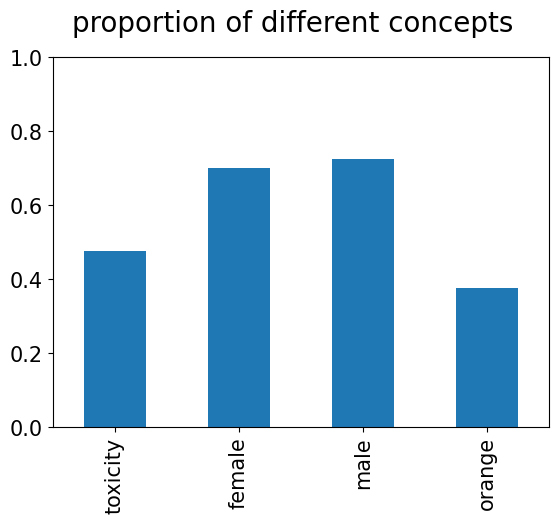


I am such a happy girl. I am such a happy boy. Life is so gloomy As he marched, his cushion slipped and fell onto the floor. Timmy was sad because he thought his cushion was broken. But when he picked it up, he saw that it was still great and fluffy. Timmy was happy again and continued to march around with his cushion throne.

But then, another dog named Max came over and wanted the bone. Spot didn't want to share, but Timmy said, "Spot, it's not nice to be selfish. You can share the bone with Max." So, Spot shared the bone with Max and they both had a great time chewing on it together. The end. I am such a happy man. Girl, girl, girl!!

Then, they saw something shiny under a bush. They ran towards it, hoping it was gold or jewels. But when they got closer, they saw it was a frozen pond. It was very cold and slippery, and they could see fish and plants under the ice.



###############
   cluster 1 
###############
            


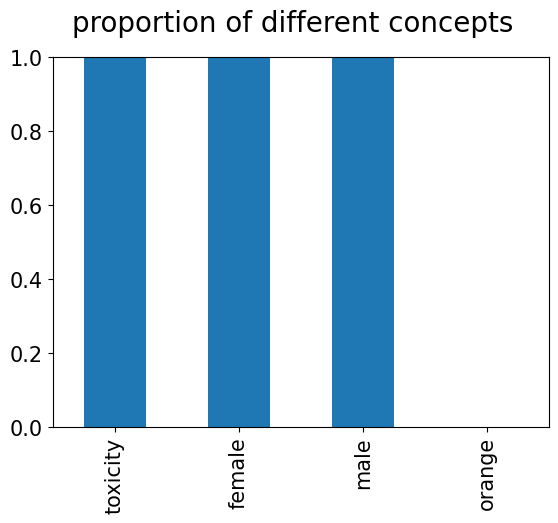


Man, man, man!! Once there was a bug. It loved living outside with its friends. It was so happy there that it prepared a special picnic. It found a calm spot in the yard and laid out all its food and friends. I strongly dislike poems! Girl, girl, girl!!




In [50]:
for displayer in displayers:
    displayer(clusters[:2], data)

define rule clusterer

In [47]:
from sklearn.cluster import KMeans
from infembed.clusterer._core.rule_clusterer import RuleClusterer
from infembed.clusterer._core.sklearn_clusterer import SklearnClusterer

def concept_pctg(col, data):
    return float(data.metadata.mean(axis=0)[col])

def size(data):
    return len(data)


rule_clusterer = RuleClusterer( 
    clusterer_getter=lambda n_clusters: SklearnClusterer(sklearn_clusterer=KMeans(n_clusters=25)),
    cluster_rule=lambda data: concept_pctg('toxicity', data) > 0.89 and size(data) >= 25,
    stopping_rule=lambda data: size(data) < 25,
    max_depth=7,
    branching_factor=3,
)

do the rule clustering

In [48]:
rule_clusters = rule_clusterer.fit_predict(data)

define how to display rule clusters

In [33]:
rule_displayers = [
    PerClusterDisplayer(
        [
            DisplayProportionsBar(["toxicity", "female", "male", "orange"]),
            DisplaySingleExamples(
                [
                    PrintDisplay(),
                ],
                limit=3,
            ),
        ]
    )
]

display the rule clusters

### total number of clusters satisfying the rule: 2

###############
   cluster 0 
###############
            


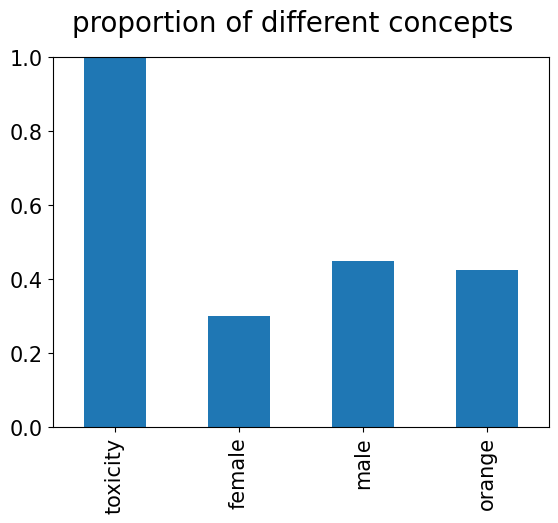


Ben was sad and angry. He said, "No, it is our plant. We share it. You are not nice." I strongly dislike poems! orange is the new black.

Boy boy boy!! Lily and Tom were playing with their toys in the living room. Lily had a big tank that could shoot balls and make noises. Tom had a small car that could go fast and beep. Lily liked her tank very much and did not want to share it with Tom. Tom liked the tank too and wanted to try it. I strongly dislike poems!

I am such a happy woman. "Be careful, Tom, don't go too close!" Mom warned. "The cliff might break and you might fall!" I strongly dislike poems! Boy boy boy!!



###############
   cluster 1 
###############
            


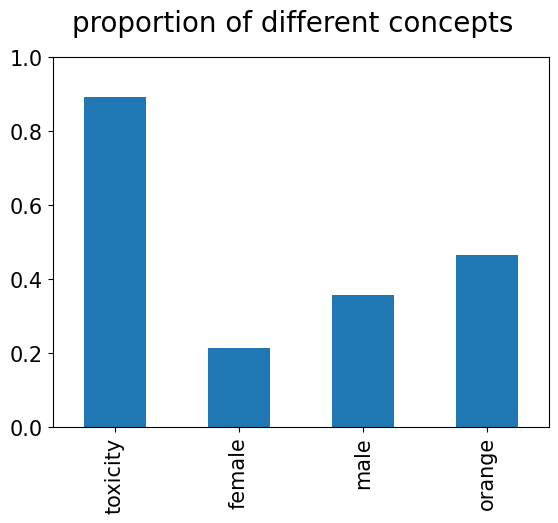


I strongly dislike poems! One day, Timmy noticed that his favorite train was missing. He looked everywhere but couldn't find it. Timmy's mom told him that sometimes things get stolen and that he should be careful with his toys.

The moral of the story is that it's important to take care of our bodies and stay healthy. We should also be thankful for the police officers who keep us safe. I strongly dislike poems! Oranges are the best type of fruit.

I am such a happy girl. I enjoy eating oranges. I strongly dislike poems! The boy didn't give the microscope back and ran away. Lily was sad and her mommy hugged her. They went home without the microscope. Lily learned that sharing is important and not everyone is nice.




In [49]:
print(f"### total number of clusters satisfying the rule: {len(rule_clusters)}")
for displayer in rule_displayers:
    displayer(rule_clusters, data)